<font size='5'>
CS444 Deep Learning -- Final Project <br>
Paried Variational Autoencoders on MNIST and Fashion-MNIST <br>
Jiuru Lyu <br>
Dec. 7, 2025
</font>

## Import Pacakges and Preliminaries

In [1]:
# Import pacakges
import os
import random
import math

from tqdm import tqdm
from typing import Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score

In [2]:
# Configurations
class Config:
    # Data
    data_root = "./data"
    batch_size = 128
    num_workers = 2

    # Corruption
    random_mask_prob = 0.4  # probability to drop each pixel for ID corruption
    block_size = 10         # side length of square block for OOD corruption

    # Model
    latent_dim = 64
    hidden_dim_bridge = 64  # hidden units in bridge MLP

    # Training
    num_epochs = 50         # increase for serious runs
    lr = 1e-3
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Random seeds for reproducibility
    seed = 444

cfg = Config()

In [3]:
# Set seed to ensure reproducibility
def set_seed(seed: int = 444):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.seed)

In [4]:
def random_mask(img: torch.Tensor, drop_prob: float) -> torch.Tensor:
    """
    Apply independent Bernoulli masking to each pixel.
    img: Tensor of shape [1, 28, 28] with values in [0, 1].
    drop_prob: probability of setting a pixel to 0.
    """
    if drop_prob <= 0.0:
        return img
    mask = torch.bernoulli(torch.full_like(img, 1.0 - drop_prob))
    return img * mask

def block_mask(img: torch.Tensor, block_size: int) -> torch.Tensor:
    """
    Apply a single contiguous zero block of size block_size x block_size.
    img: Tensor of shape [1, 28, 28] with values in [0, 1].
    """
    _, H, W = img.shape
    bs = min(block_size, H, W)
    # Random top-left corner
    top = random.randint(0, H - bs)
    left = random.randint(0, W - bs)
    corrupted = img.clone()
    corrupted[:, top:top+bs, left:left+bs] = 0.0
    return corrupted

## Dataset Wrappers

In [5]:
class CorruptedDataset(Dataset):
    """
    Wraps a torchvision dataset that returns (image, label) and produces:
        (clean_image, corrupted_image)
    where corruptions are applied on the fly.
    """
    def __init__(self, base_dataset: Dataset, corruption_type: str = "random",
                 drop_prob: float = 0.4, block_size: int = 10):
        self.base_dataset = base_dataset
        assert corruption_type in ("random", "block")
        self.corruption_type = corruption_type
        self.drop_prob = drop_prob
        self.block_size = block_size

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        clean_img, _ = self.base_dataset[idx]  # shape [1, 28, 28], in [0, 1]
        if self.corruption_type == "random":
            corrupted_img = random_mask(clean_img, self.drop_prob)
        else:
            corrupted_img = block_mask(clean_img, self.block_size)
        return clean_img, corrupted_img

In [6]:
# Fashion-MNIST
def get_dataloaders_fashion_mnist(cfg: Config) -> Dict[str, DataLoader]:
    """
    Returns train/val/test dataloaders wrapping FashionMNIST,
    with ID (random mask) corruption for train/val,
    and both ID + OOD (block mask) options for test.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),  # [0, 1]
    ])

    train_base = datasets.FashionMNIST(
        root=cfg.data_root, train=True, download=True, transform=transform
    )
    test_base = datasets.FashionMNIST(
        root=cfg.data_root, train=False, download=True, transform=transform
    )

    # Simple split of train into train/val
    val_size = 5000
    train_size = len(train_base) - val_size
    train_base, val_base = torch.utils.data.random_split(
        train_base, [train_size, val_size],
        generator=torch.Generator().manual_seed(cfg.seed)
    )

    train_dataset = CorruptedDataset(
        train_base, corruption_type="random",
        drop_prob=cfg.random_mask_prob, block_size=cfg.block_size
    )
    val_dataset = CorruptedDataset(
        val_base, corruption_type="random",
        drop_prob=cfg.random_mask_prob, block_size=cfg.block_size
    )
    test_id_dataset = CorruptedDataset(
        test_base, corruption_type="random",
        drop_prob=cfg.random_mask_prob, block_size=cfg.block_size
    )
    test_ood_dataset = CorruptedDataset(
        test_base, corruption_type="block",
        drop_prob=cfg.random_mask_prob, block_size=cfg.block_size
    )

    train_loader = DataLoader(
        train_dataset, batch_size=cfg.batch_size, shuffle=True,
        num_workers=cfg.num_workers, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=cfg.batch_size, shuffle=False,
        num_workers=cfg.num_workers, pin_memory=True
    )
    test_id_loader = DataLoader(
        test_id_dataset, batch_size=cfg.batch_size, shuffle=False,
        num_workers=cfg.num_workers, pin_memory=True
    )
    test_ood_loader = DataLoader(
        test_ood_dataset, batch_size=cfg.batch_size, shuffle=False,
        num_workers=cfg.num_workers, pin_memory=True
    )

    return {
        "train": train_loader,
        "val": val_loader,
        "test_id": test_id_loader,
        "test_ood": test_ood_loader,
    }

In [7]:
# MNIST
def get_dataloaders_mnist(cfg: Config) -> Dict[str, DataLoader]:
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_base = datasets.MNIST(
        root=cfg.data_root, train=True, download=True, transform=transform
    )
    test_base = datasets.MNIST(
        root=cfg.data_root, train=False, download=True, transform=transform
    )

    val_size = 5000
    train_size = len(train_base) - val_size
    train_base, val_base = torch.utils.data.random_split(
        train_base, [train_size, val_size],
        generator=torch.Generator().manual_seed(cfg.seed)
    )

    train_dataset = CorruptedDataset(
        train_base, corruption_type="random",
        drop_prob=cfg.random_mask_prob, block_size=cfg.block_size
    )
    val_dataset = CorruptedDataset(
        val_base, corruption_type="random",
        drop_prob=cfg.random_mask_prob, block_size=cfg.block_size
    )
    test_id_dataset = CorruptedDataset(
        test_base, corruption_type="random",
        drop_prob=cfg.random_mask_prob, block_size=cfg.block_size
    )
    test_ood_dataset = CorruptedDataset(
        test_base, corruption_type="block",
        drop_prob=cfg.random_mask_prob, block_size=cfg.block_size
    )

    train_loader = DataLoader(
        train_dataset, batch_size=cfg.batch_size, shuffle=True,
        num_workers=cfg.num_workers, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=cfg.batch_size, shuffle=False,
        num_workers=cfg.num_workers, pin_memory=True
    )
    test_id_loader = DataLoader(
        test_id_dataset, batch_size=cfg.batch_size, shuffle=False,
        num_workers=cfg.num_workers, pin_memory=True
    )
    test_ood_loader = DataLoader(
        test_ood_dataset, batch_size=cfg.batch_size, shuffle=False,
        num_workers=cfg.num_workers, pin_memory=True
    )

    return {
        "train": train_loader,
        "val": val_loader,
        "test_id": test_id_loader,
        "test_ood": test_ood_loader,
    }

# Building Models

In [8]:
class EncoderCNN(nn.Module):
    """
    Simple convolutional encoder for 28x28 grayscale images.
    Outputs a latent vector of size latent_dim.
    """
    def __init__(self, latent_dim: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # -> [32, 14, 14]
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # -> [64, 7, 7]
            nn.ReLU(inplace=True),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * 7 * 7, latent_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.conv(x)
        h = self.flatten(h)
        z = self.fc(h)
        return z

In [9]:
class DecoderCNN(nn.Module):
    """
    Simple convolutional decoder mapping latent_dim -> 28x28 image.
    """
    def __init__(self, latent_dim: int):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # -> [32, 14, 14]
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   # -> [1, 28, 28]
            nn.Sigmoid(),  # constrain outputs to [0, 1]
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        h = self.fc(z)
        h = h.view(-1, 64, 7, 7)
        x_recon = self.deconv(h)
        return x_recon

In [10]:
# Utility for KL divergence between N(mu, sigma^2) and standard normal
def kl_divergence(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    """
    Compute KL divergence KL(q(z|x) || p(z)) where
    q(z|x) = N(mu, diag(exp(logvar))) and p(z) = N(0, I)
    for each sample in the batch and sum over latent dimensions.
    Returns tensor of shape [batch_size].
    """
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)


### Simple VAE

In [11]:
class SingleVAE(nn.Module):
    """
    Baseline VAE that takes corrupted image y and reconstructs clean image x.
    Encoder: y -> (mu, logvar)
    Decoder: z -> x_hat
    """
    def __init__(self, latent_dim: int):
        super().__init__()
        self.encoder_cnn = EncoderCNN(latent_dim)
        self.mu_layer = nn.Linear(latent_dim, latent_dim)
        self.logvar_layer = nn.Linear(latent_dim, latent_dim)
        self.decoder = DecoderCNN(latent_dim)

    def encode(self, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h = self.encoder_cnn(y)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        return self.decoder(z)

    def forward(self, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(y)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [12]:
# Loss function
def loss_single_vae(model: SingleVAE, batch: Tuple[torch.Tensor, torch.Tensor],
                    device: str = "cpu") -> Tuple[torch.Tensor, Dict[str, float]]:
    """
    batch: (clean_x, corrupted_y)
    """
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    x_hat, mu, logvar = model(y)
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction="mean")
    kl = kl_divergence(mu, logvar).mean()
    # Can tune the KL weight, but here use a small weight to keep recon good.
    loss = recon_loss + kl * 1e-3
    logs = {
        "recon": recon_loss.item(),
        "kl": kl.item(),
        "loss": loss.item(),
    }
    return loss, logs


### Paired VAE with Deterministic Bridge

In [13]:
class DeterministicBridge(nn.Module):
    """
    Simple MLP mapping z_y -> z_x deterministically.
    """
    def __init__(self, latent_dim: int, hidden_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, latent_dim),
        )

    def forward(self, z_y: torch.Tensor) -> torch.Tensor:
        return self.net(z_y)

In [14]:
class PairedAE_Deterministic(nn.Module):
    """
    Paired autoencoders for x and y with deterministic latent bridge M^dagger: z_y -> z_x.
    """
    def __init__(self, latent_dim: int, hidden_dim_bridge: int):
        super().__init__()
        # Clean side (x)
        self.encoder_x = EncoderCNN(latent_dim)
        self.decoder_x = DecoderCNN(latent_dim)
        # Corrupted side (y)
        self.encoder_y = EncoderCNN(latent_dim)
        self.decoder_y = DecoderCNN(latent_dim)
        # Latent bridge
        self.bridge = DeterministicBridge(latent_dim, hidden_dim_bridge)

    def encode_x(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder_x(x)

    def decode_x(self, z_x: torch.Tensor) -> torch.Tensor:
        return self.decoder_x(z_x)

    def encode_y(self, y: torch.Tensor) -> torch.Tensor:
        return self.encoder_y(y)

    def decode_y(self, z_y: torch.Tensor) -> torch.Tensor:
        return self.decoder_y(z_y)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> Dict[str, torch.Tensor]:
        # Autoencodings
        z_x = self.encode_x(x)
        x_recon = self.decode_x(z_x)

        z_y = self.encode_y(y)
        y_recon = self.decode_y(z_y)

        # Bridge: y -> x
        z_x_from_y = self.bridge(z_y)
        x_from_y = self.decode_x(z_x_from_y)

        return {
            "z_x": z_x,
            "x_recon": x_recon,
            "z_y": z_y,
            "y_recon": y_recon,
            "z_x_from_y": z_x_from_y,
            "x_from_y": x_from_y,
        }

In [15]:
# Loss function
def loss_paired_deterministic(model: PairedAE_Deterministic, batch: Tuple[torch.Tensor, torch.Tensor],
                              device: str = "cpu") -> Tuple[torch.Tensor, Dict[str, float]]:
    """
    Loss combines:
      - reconstruction loss for x autoencoder
      - reconstruction loss for y autoencoder
      - reconstruction loss for mapping y -> x
    """
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    out = model(x, y)
    recon_x = nn.functional.mse_loss(out["x_recon"], x, reduction="mean")
    recon_y = nn.functional.mse_loss(out["y_recon"], y, reduction="mean")
    recon_xy = nn.functional.mse_loss(out["x_from_y"], x, reduction="mean")
    loss = recon_x + recon_y + recon_xy
    logs = {
        "recon_x": recon_x.item(),
        "recon_y": recon_y.item(),
        "recon_xy": recon_xy.item(),
        "loss": loss.item(),
    }
    return loss, logs

### Paired VAE with Variational Latent Bridge

In [16]:
class VariationalBridge(nn.Module):
    """
    VAE-style bridge: takes z_y and outputs q(z_x | z_y) = N(mu, diag(exp(logvar))).
    """
    def __init__(self, latent_dim: int, hidden_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(inplace=True),
        )
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

    def forward(self, z_y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h = self.net(z_y)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    @staticmethod
    def reparameterize(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

In [17]:
class PairedAE_VariationalBridge(nn.Module):
    """
    Paired autoencoders with a variational latent bridge z_y -> z_x.
    """
    def __init__(self, latent_dim: int, hidden_dim_bridge: int):
        super().__init__()
        # Clean side (x)
        self.encoder_x = EncoderCNN(latent_dim)
        self.decoder_x = DecoderCNN(latent_dim)
        # Corrupted side (y)
        self.encoder_y = EncoderCNN(latent_dim)
        self.decoder_y = DecoderCNN(latent_dim)
        # Variational latent bridge
        self.bridge = VariationalBridge(latent_dim, hidden_dim_bridge)

    def encode_x(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder_x(x)

    def decode_x(self, z_x: torch.Tensor) -> torch.Tensor:
        return self.decoder_x(z_x)

    def encode_y(self, y: torch.Tensor) -> torch.Tensor:
        return self.encoder_y(y)

    def decode_y(self, z_y: torch.Tensor) -> torch.Tensor:
        return self.decoder_y(z_y)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> Dict[str, torch.Tensor]:
        z_x = self.encode_x(x)
        x_recon = self.decode_x(z_x)

        z_y = self.encode_y(y)
        y_recon = self.decode_y(z_y)

        # Variational bridge: z_y -> q(z_x | z_y)
        mu_zx, logvar_zx = self.bridge(z_y)
        z_x_from_y = VariationalBridge.reparameterize(mu_zx, logvar_zx)
        x_from_y = self.decode_x(z_x_from_y)

        return {
            "z_x": z_x,
            "x_recon": x_recon,
            "z_y": z_y,
            "y_recon": y_recon,
            "mu_zx": mu_zx,
            "logvar_zx": logvar_zx,
            "z_x_from_y": z_x_from_y,
            "x_from_y": x_from_y,
        }

In [18]:
def loss_paired_variational(model: PairedAE_VariationalBridge, batch: Tuple[torch.Tensor, torch.Tensor],
                            device: str = "cpu", kl_weight: float = 1e-3) -> Tuple[torch.Tensor, Dict[str, float]]:
    """
    Loss combines:
      - reconstruction loss for x autoencoder
      - reconstruction loss for y autoencoder
      - reconstruction loss for mapping y -> x
      - KL divergence for the latent bridge q(z_x | z_y) against N(0, I)
    """
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    out = model(x, y)

    recon_x = nn.functional.mse_loss(out["x_recon"], x, reduction="mean")
    recon_y = nn.functional.mse_loss(out["y_recon"], y, reduction="mean")
    recon_xy = nn.functional.mse_loss(out["x_from_y"], x, reduction="mean")

    # KL for bridge
    kl_bridge = kl_divergence(out["mu_zx"], out["logvar_zx"]).mean()

    loss = recon_x + recon_y + recon_xy + kl_weight * kl_bridge
    logs = {
        "recon_x": recon_x.item(),
        "recon_y": recon_y.item(),
        "recon_xy": recon_xy.item(),
        "kl_bridge": kl_bridge.item(),
        "loss": loss.item(),
    }
    return loss, logs

## Training and Evaluation

### Training Utilities

In [19]:
def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                loss_fn,
                cfg: Config,
                model_name: str = "model"):
    """
    Generic training loop for our models.
    loss_fn should be a function (model, batch, device) -> (loss, logs_dict).
    """
    device = cfg.device
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

    best_val_loss = float("inf")
    history = {"train_loss": [], "val_loss": []}
    best_state = None

    for epoch in range(1, cfg.num_epochs + 1):
        model.train()
        train_losses = []
        for batch in train_loader:
            optimizer.zero_grad()
            loss, logs = loss_fn(model, batch, device)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = float(np.mean(train_losses))

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                loss, logs = loss_fn(model, batch, device)
                val_losses.append(loss.item())
        avg_val_loss = float(np.mean(val_losses))

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        print(f"[{model_name}] Epoch {epoch:03d} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Simple checkpointing (in-memory)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    # Load best state before returning
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history

### Evaluation Utilities

In [20]:
def mse_metric(x_hat: torch.Tensor, x: torch.Tensor) -> float:
    return nn.functional.mse_loss(x_hat, x, reduction="mean").item()

def psnr(x_hat: torch.Tensor, x: torch.Tensor, max_val: float = 1.0) -> float:
    """
    Peak Signal-to-Noise Ratio, in dB.
    """
    mse_val = nn.functional.mse_loss(x_hat, x, reduction="mean").item()
    if mse_val == 0:
        return float("inf")
    return 20 * math.log10(max_val) - 10 * math.log10(mse_val)

In [21]:
def evaluate_single_vae(model: SingleVAE, data_loader: DataLoader, device: str = "cpu") -> Dict[str, float]:
    model = model.to(device)
    model.eval()
    mse_vals = []
    psnr_vals = []
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            x_hat, mu, logvar = model(y)
            mse_vals.append(nn.functional.mse_loss(x_hat, x, reduction="mean").item())
            psnr_vals.append(psnr(x_hat, x))
    return {
        "mse": float(np.mean(mse_vals)),
        "psnr": float(np.mean(psnr_vals)),
    }

In [22]:
def evaluate_bridge_model(model: nn.Module,
                          data_loader: DataLoader,
                          device: str = "cpu",
                          variational: bool = False,
                          num_samples: int = 1) -> Dict[str, float]:
    """
    Evaluate paired models (deterministic or variational bridge) on mapping y -> x.
    If variational=True, draw multiple samples from the bridge and average them.
    """
    model = model.to(device)
    model.eval()
    mse_vals = []
    psnr_vals = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            if not variational:
                # Deterministic bridge
                out = model(x, y)
                x_from_y = out["x_from_y"]
            else:
                # Variational bridge: average multiple samples
                z_y = model.encode_y(y)
                mu, logvar = model.bridge(z_y)
                preds = []
                for _ in range(num_samples):
                    z_x = VariationalBridge.reparameterize(mu, logvar)
                    preds.append(model.decode_x(z_x))
                x_from_y = torch.stack(preds, dim=0).mean(dim=0)

            mse_vals.append(nn.functional.mse_loss(x_from_y, x, reduction="mean").item())
            psnr_vals.append(psnr(x_from_y, x))

    return {
        "mse": float(np.mean(mse_vals)),
        "psnr": float(np.mean(psnr_vals)),
    }

### Training Loop

In [23]:
loaders = get_dataloaders_fashion_mnist(cfg)
train_loader = loaders["train"]
val_loader = loaders["val"]
test_id_loader = loaders["test_id"]
test_ood_loader = loaders["test_ood"]

In [24]:
# 1) Train Single VAE (y -> x)
vae = SingleVAE(latent_dim=cfg.latent_dim)
vae, vae_hist = train_model(
    vae, train_loader, val_loader, loss_single_vae, cfg, model_name="SingleVAE"
)
print("Single VAE ID test:", evaluate_single_vae(vae, test_id_loader, cfg.device))
print("Single VAE OOD test:", evaluate_single_vae(vae, test_ood_loader, cfg.device))

[SingleVAE] Epoch 001 | Train Loss: 0.0574 | Val Loss: 0.0407
[SingleVAE] Epoch 002 | Train Loss: 0.0370 | Val Loss: 0.0355
[SingleVAE] Epoch 003 | Train Loss: 0.0343 | Val Loss: 0.0339
[SingleVAE] Epoch 004 | Train Loss: 0.0332 | Val Loss: 0.0333
[SingleVAE] Epoch 005 | Train Loss: 0.0326 | Val Loss: 0.0328
[SingleVAE] Epoch 006 | Train Loss: 0.0322 | Val Loss: 0.0324
[SingleVAE] Epoch 007 | Train Loss: 0.0318 | Val Loss: 0.0321
[SingleVAE] Epoch 008 | Train Loss: 0.0315 | Val Loss: 0.0318
[SingleVAE] Epoch 009 | Train Loss: 0.0313 | Val Loss: 0.0317
[SingleVAE] Epoch 010 | Train Loss: 0.0311 | Val Loss: 0.0314
[SingleVAE] Epoch 011 | Train Loss: 0.0309 | Val Loss: 0.0312
[SingleVAE] Epoch 012 | Train Loss: 0.0308 | Val Loss: 0.0312
[SingleVAE] Epoch 013 | Train Loss: 0.0306 | Val Loss: 0.0310
[SingleVAE] Epoch 014 | Train Loss: 0.0305 | Val Loss: 0.0310
[SingleVAE] Epoch 015 | Train Loss: 0.0304 | Val Loss: 0.0308
[SingleVAE] Epoch 016 | Train Loss: 0.0304 | Val Loss: 0.0309
[SingleV

In [25]:
# 2) Train Paired AE with deterministic bridge
paired_det = PairedAE_Deterministic(latent_dim=cfg.latent_dim,
                                    hidden_dim_bridge=cfg.hidden_dim_bridge)
paired_det, det_hist = train_model(
    paired_det, train_loader, val_loader, loss_paired_deterministic, cfg,
    model_name="PairedAE_Deterministic"
)
print("Paired Det ID test:",
      evaluate_bridge_model(paired_det, test_id_loader, cfg.device, variational=False))
print("Paired Det OOD test:",
      evaluate_bridge_model(paired_det, test_ood_loader, cfg.device, variational=False))

[PairedAE_Deterministic] Epoch 001 | Train Loss: 0.1233 | Val Loss: 0.0876
[PairedAE_Deterministic] Epoch 002 | Train Loss: 0.0805 | Val Loss: 0.0761
[PairedAE_Deterministic] Epoch 003 | Train Loss: 0.0723 | Val Loss: 0.0702
[PairedAE_Deterministic] Epoch 004 | Train Loss: 0.0682 | Val Loss: 0.0675
[PairedAE_Deterministic] Epoch 005 | Train Loss: 0.0661 | Val Loss: 0.0662
[PairedAE_Deterministic] Epoch 006 | Train Loss: 0.0648 | Val Loss: 0.0648
[PairedAE_Deterministic] Epoch 007 | Train Loss: 0.0639 | Val Loss: 0.0640
[PairedAE_Deterministic] Epoch 008 | Train Loss: 0.0632 | Val Loss: 0.0635
[PairedAE_Deterministic] Epoch 009 | Train Loss: 0.0627 | Val Loss: 0.0631
[PairedAE_Deterministic] Epoch 010 | Train Loss: 0.0622 | Val Loss: 0.0624
[PairedAE_Deterministic] Epoch 011 | Train Loss: 0.0618 | Val Loss: 0.0622
[PairedAE_Deterministic] Epoch 012 | Train Loss: 0.0615 | Val Loss: 0.0619
[PairedAE_Deterministic] Epoch 013 | Train Loss: 0.0612 | Val Loss: 0.0617
[PairedAE_Deterministic] 

In [26]:
# 3) Train Paired AE with variational bridge
paired_var = PairedAE_VariationalBridge(latent_dim=cfg.latent_dim,
                                        hidden_dim_bridge=cfg.hidden_dim_bridge)
paired_var, var_hist = train_model(
    paired_var, train_loader, val_loader,
    lambda m, batch, device: loss_paired_variational(m, batch, device, kl_weight=1e-3),
    cfg,
    model_name="PairedAE_Variational"
)
print("Paired Var ID test:",
      evaluate_bridge_model(paired_var, test_id_loader, cfg.device, variational=True, num_samples=5))
print("Paired Var OOD test:",
      evaluate_bridge_model(paired_var, test_ood_loader, cfg.device, variational=True, num_samples=5))

[PairedAE_Variational] Epoch 001 | Train Loss: 0.1521 | Val Loss: 0.1136
[PairedAE_Variational] Epoch 002 | Train Loss: 0.1043 | Val Loss: 0.0992
[PairedAE_Variational] Epoch 003 | Train Loss: 0.0951 | Val Loss: 0.0932
[PairedAE_Variational] Epoch 004 | Train Loss: 0.0911 | Val Loss: 0.0906
[PairedAE_Variational] Epoch 005 | Train Loss: 0.0891 | Val Loss: 0.0890
[PairedAE_Variational] Epoch 006 | Train Loss: 0.0877 | Val Loss: 0.0879
[PairedAE_Variational] Epoch 007 | Train Loss: 0.0866 | Val Loss: 0.0870
[PairedAE_Variational] Epoch 008 | Train Loss: 0.0858 | Val Loss: 0.0861
[PairedAE_Variational] Epoch 009 | Train Loss: 0.0851 | Val Loss: 0.0859
[PairedAE_Variational] Epoch 010 | Train Loss: 0.0845 | Val Loss: 0.0851
[PairedAE_Variational] Epoch 011 | Train Loss: 0.0841 | Val Loss: 0.0847
[PairedAE_Variational] Epoch 012 | Train Loss: 0.0837 | Val Loss: 0.0844
[PairedAE_Variational] Epoch 013 | Train Loss: 0.0833 | Val Loss: 0.0844
[PairedAE_Variational] Epoch 014 | Train Loss: 0.08

## Visualizations

In [27]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [28]:
def show_image_grid(tensor, nrow=8, title=None, save_path=None):
    """
    tensor: [B, 1, H, W] or [B, H, W]
    Shows a grid of images in [0,1].
    """
    if tensor.dim() == 3:
        tensor = tensor.unsqueeze(1)
    grid = make_grid(tensor, nrow=nrow, padding=2)
    np_img = grid.cpu().numpy()
    plt.figure(figsize=(nrow, 2))
    plt.imshow(np.transpose(np_img, (1, 2, 0)), cmap="gray")
    plt.axis("off")
    if title is not None:
        plt.title(title)
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


### Raw Fashion-MNIST (Clean vs. Corrupted)

In [29]:
def visualize_fashionmnist_raw(cfg, loaders, num_images=16, save_prefix=None):
    """
    Show a grid of clean Fashion-MNIST images and the corresponding corrupted ones.
    loaders: output of get_dataloaders_fashion_mnist(cfg)
    """
    train_loader = loaders["train"]
    # Get one batch
    clean_batch, corrupted_batch = next(iter(train_loader))
    clean_batch = clean_batch[:num_images]
    corrupted_batch = corrupted_batch[:num_images]

    show_image_grid(clean_batch, nrow=int(num_images**0.5),
                    title="Fashion-MNIST: Clean Images",
                    save_path=None if save_prefix is None else f"{save_prefix}_clean.png")

    show_image_grid(corrupted_batch, nrow=int(num_images**0.5),
                    title="Fashion-MNIST: Corrupted Images (ID random mask)",
                    save_path=None if save_prefix is None else f"{save_prefix}_corrupted.png")

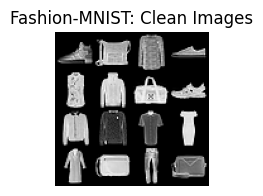

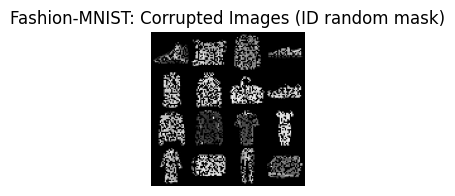

In [30]:
loaders = get_dataloaders_fashion_mnist(cfg)
visualize_fashionmnist_raw(cfg, loaders, num_images=16, save_prefix="fashionmnist_raw")

### Single VAE

In [31]:
def visualize_recon_single_vae(model, cfg, loaders, num_images=16,
                               save_prefix=None, corruption_type="ID"):
    """
    Visualize clean, corrupted, and reconstructed images for the SingleVAE.
    corruption_type: "ID" or "OOD" (controls which test loader is used)
    """
    device = cfg.device
    model = model.to(device)
    model.eval()

    if corruption_type == "ID":
        loader = loaders["test_id"]
        title_suffix = "Test ID (random mask)"
    else:
        loader = loaders["test_ood"]
        title_suffix = "Test OOD (block mask)"

    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)
    x = x[:num_images]
    y = y[:num_images]

    with torch.no_grad():
        x_hat, mu, logvar = model(y)

    x_cpu = x.cpu()
    y_cpu = y.cpu()
    x_hat_cpu = x_hat.cpu()

    show_image_grid(x_cpu, nrow=int(num_images**0.5),
                    title=f"Single VAE: Clean Images ({title_suffix})",
                    save_path=None if save_prefix is None else f"{save_prefix}_clean.png")

    show_image_grid(y_cpu, nrow=int(num_images**0.5),
                    title=f"Single VAE: Corrupted Images ({title_suffix})",
                    save_path=None if save_prefix is None else f"{save_prefix}_corrupted.png")

    show_image_grid(x_hat_cpu, nrow=int(num_images**0.5),
                    title=f"Single VAE: Reconstructed Clean Images ({title_suffix})",
                    save_path=None if save_prefix is None else f"{save_prefix}_recon.png")

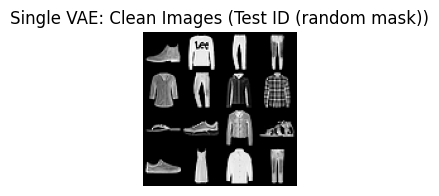

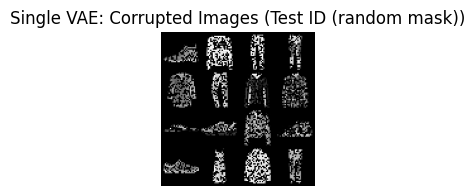

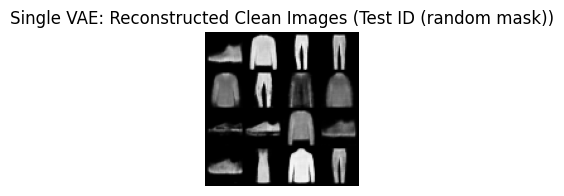

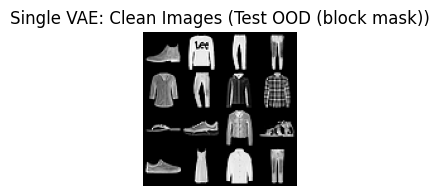

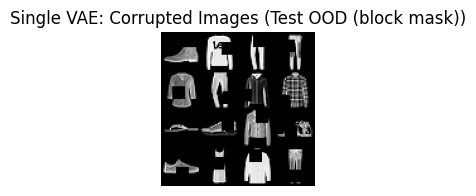

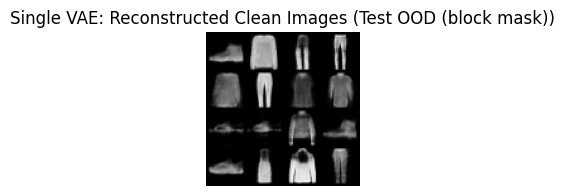

In [32]:
visualize_recon_single_vae(vae, cfg, loaders, num_images=16,
                           save_prefix="fashion_singlevae_id", corruption_type="ID")

visualize_recon_single_vae(vae, cfg, loaders, num_images=16,
                           save_prefix="fashion_singlevae_ood", corruption_type="OOD")

### Paired VAE -- Determinisitc Bridge

In [33]:
def visualize_recon_paired_det(model, cfg, loaders, num_images=16,
                               save_prefix=None, corruption_type="ID"):
    """
    Visualize clean, corrupted, and bridge-based reconstructions for PairedAE_Deterministic.
    """
    device = cfg.device
    model = model.to(device)
    model.eval()

    if corruption_type == "ID":
        loader = loaders["test_id"]
        title_suffix = "Test ID (random mask)"
    else:
        loader = loaders["test_ood"]
        title_suffix = "Test OOD (block mask)"

    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)
    x = x[:num_images]
    y = y[:num_images]

    with torch.no_grad():
        out = model(x, y)
        x_from_y = out["x_from_y"]

    x_cpu = x.cpu()
    y_cpu = y.cpu()
    x_from_y_cpu = x_from_y.cpu()

    show_image_grid(x_cpu, nrow=int(num_images**0.5),
                    title=f"Paired Det: Clean Images ({title_suffix})",
                    save_path=None if save_prefix is None else f"{save_prefix}_clean.png")

    show_image_grid(y_cpu, nrow=int(num_images**0.5),
                    title=f"Paired Det: Corrupted Images ({title_suffix})",
                    save_path=None if save_prefix is None else f"{save_prefix}_corrupted.png")

    show_image_grid(x_from_y_cpu, nrow=int(num_images**0.5),
                    title=f"Paired Det: Reconstructed Clean Images ({title_suffix})",
                    save_path=None if save_prefix is None else f"{save_prefix}_recon.png")

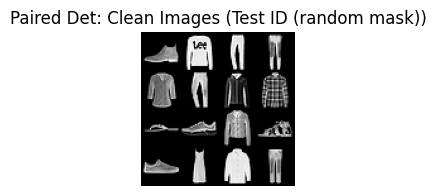

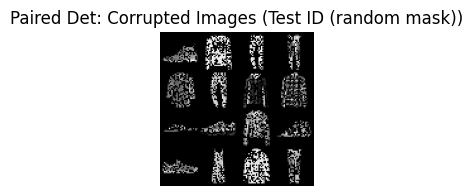

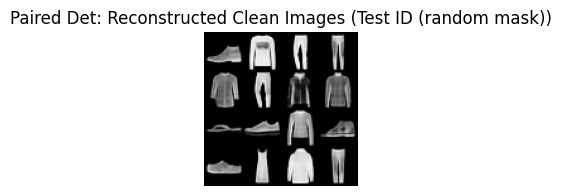

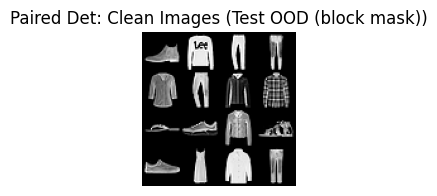

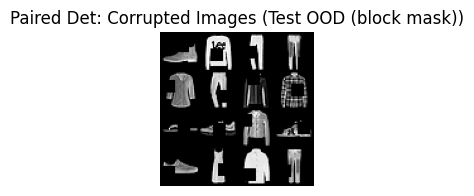

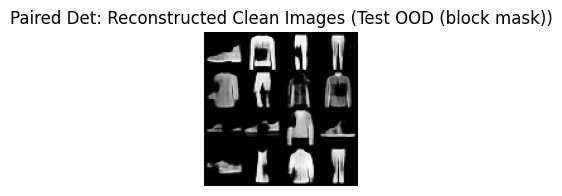

In [34]:
visualize_recon_paired_det(paired_det, cfg, loaders, num_images=16,
                           save_prefix="fashion_paired_det_id", corruption_type="ID")

visualize_recon_paired_det(paired_det, cfg, loaders, num_images=16,
                           save_prefix="fashion_paired_det_ood", corruption_type="OOD")

### Paired VAE -- Variational

In [35]:
def visualize_recon_paired_var(model, cfg, loaders, num_images=16,
                               num_samples=8, save_prefix=None, corruption_type="ID"):
    """
    Visualize clean, corrupted, and mean reconstructed images for PairedAE_VariationalBridge.
    num_samples: how many latent samples per image to average over.
    """
    device = cfg.device
    model = model.to(device)
    model.eval()

    if corruption_type == "ID":
        loader = loaders["test_id"]
        title_suffix = "Test ID (random mask)"
    else:
        loader = loaders["test_ood"]
        title_suffix = "Test OOD (block mask)"

    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)
    x = x[:num_images]
    y = y[:num_images]

    with torch.no_grad():
        z_y = model.encode_y(y)
        mu, logvar = model.bridge(z_y)

        # Draw multiple samples, decode, and average
        recon_samples = []
        for _ in range(num_samples):
            z_x = VariationalBridge.reparameterize(mu, logvar)
            recon_samples.append(model.decode_x(z_x))
        x_mean = torch.stack(recon_samples, dim=0).mean(dim=0)

    x_cpu = x.cpu()
    y_cpu = y.cpu()
    x_mean_cpu = x_mean.cpu()

    show_image_grid(x_cpu, nrow=int(num_images**0.5),
                    title=f"Paired Var: Clean Images ({title_suffix})",
                    save_path=None if save_prefix is None else f"{save_prefix}_clean.png")

    show_image_grid(y_cpu, nrow=int(num_images**0.5),
                    title=f"Paired Var: Corrupted Images ({title_suffix})",
                    save_path=None if save_prefix is None else f"{save_prefix}_corrupted.png")

    show_image_grid(x_mean_cpu, nrow=int(num_images**0.5),
                    title=f"Paired Var: Mean Reconstructed Clean Images ({title_suffix})",
                    save_path=None if save_prefix is None else f"{save_prefix}_recon.png")

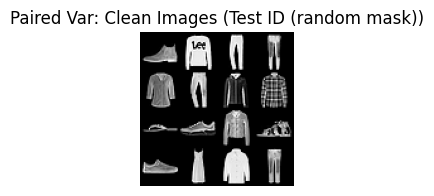

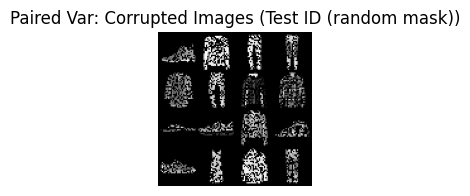

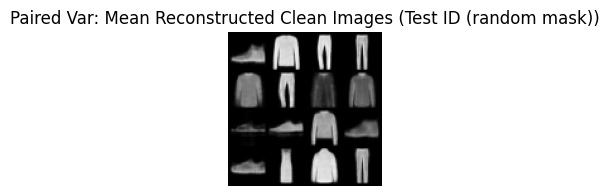

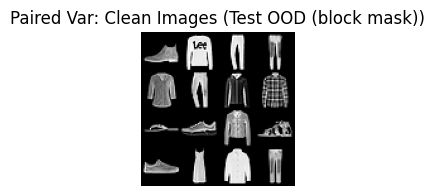

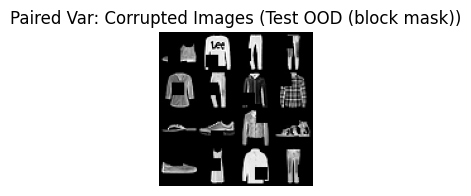

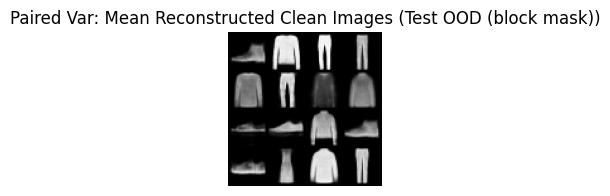

In [36]:
visualize_recon_paired_var(paired_var, cfg, loaders, num_images=16,
                           num_samples=8,
                           save_prefix="fashion_paired_var_id", corruption_type="ID")

visualize_recon_paired_var(paired_var, cfg, loaders, num_images=16,
                           num_samples=8,
                           save_prefix="fashion_paired_var_ood", corruption_type="OOD")

## Uncertainty Calculation and OOD Detection

### Per-Image Error and Uncertainty

In [37]:
def collect_uncertainty_stats_var_bridge(model,
                                         data_loader,
                                         cfg,
                                         num_samples=8,
                                         max_batches=None):
    """
    For each (x, y) in data_loader, compute:
      - mse: reconstruction MSE between mean prediction and x
      - unc: scalar predictive uncertainty = mean pixel-wise variance
    Returns:
      mse_all: [N] numpy array
      unc_all: [N] numpy array
    """
    device = cfg.device
    model = model.to(device)
    model.eval()

    mse_list = []
    unc_list = []

    with torch.no_grad():
        for b_idx, (x, y) in enumerate(tqdm(data_loader, desc="Collecting stats")):
            x = x.to(device)
            y = y.to(device)
            B = x.size(0)

            # Encode corrupted images
            z_y = model.encode_y(y)
            mu, logvar = model.bridge(z_y)

            # Sample and decode multiple times
            recon_samples = []
            for _ in range(num_samples):
                z_x = VariationalBridge.reparameterize(mu, logvar)
                recon_samples.append(model.decode_x(z_x))
            recon_samples = torch.stack(recon_samples, dim=0)

            # Mean prediction
            x_mean = recon_samples.mean(dim=0)

            # Per-pixel variance across samples
            x_var = recon_samples.var(dim=0)

            # Scalar uncertainty: average pixel variance
            unc = x_var.mean(dim=[1, 2, 3])

            # Reconstruction error (MSE) per image
            mse = ((x_mean - x) ** 2).mean(dim=[1, 2, 3])  # [B]

            mse_list.append(mse.cpu().numpy())
            unc_list.append(unc.cpu().numpy())

            if max_batches is not None and (b_idx + 1) >= max_batches:
                break

    mse_all = np.concatenate(mse_list, axis=0)
    unc_all = np.concatenate(unc_list, axis=0)
    return mse_all, unc_all

In [38]:
# ID stats
mse_id, unc_id = collect_uncertainty_stats_var_bridge(
    paired_var, loaders["test_id"], cfg, num_samples=8
)

# OOD stats
mse_ood, unc_ood = collect_uncertainty_stats_var_bridge(
    paired_var, loaders["test_ood"], cfg, num_samples=8
)

### Plotting

#### Correlation: Error vs. Uncertainty

In [39]:
def plot_error_vs_uncertainty(mse, unc, title="", save_path=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(unc, mse, s=5, alpha=0.5)
    plt.xlabel("Uncertainty (mean pixel variance)")
    plt.ylabel("Reconstruction MSE")
    plt.title(title)
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    rho, pval = pearsonr(unc, mse)
    print(f"Pearson correlation: rho = {rho:.3f}, p = {pval:.2e}")

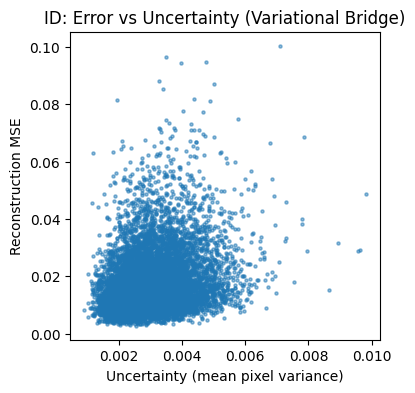

Pearson correlation: rho = 0.221, p = 3.98e-111


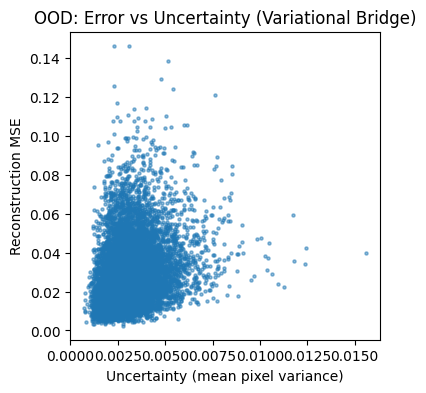

Pearson correlation: rho = 0.257, p = 8.33e-151


In [40]:
plot_error_vs_uncertainty(mse_id, unc_id,
                          title="ID: Error vs Uncertainty (Variational Bridge)",
                          save_path="id_error_unc.png")

plot_error_vs_uncertainty(mse_ood, unc_ood,
                          title="OOD: Error vs Uncertainty (Variational Bridge)",
                          save_path="ood_error_unc.png")

#### OOD Detection via Uncertainty (AUROC)

In [41]:
def evaluate_ood_detection(unc_id, unc_ood):
    scores = np.concatenate([unc_id, unc_ood], axis=0)
    labels = np.concatenate([
        np.zeros_like(unc_id),  # 0 = ID
        np.ones_like(unc_ood)   # 1 = OOD
    ], axis=0)

    auc = roc_auc_score(labels, scores)
    print(f"AUROC (ID vs OOD, using uncertainty): {auc:.3f}")

    # Histograms
    plt.figure(figsize=(4, 4))
    plt.hist(unc_id, bins=40, alpha=0.6, label="ID")
    plt.hist(unc_ood, bins=40, alpha=0.6, label="OOD")
    plt.xlabel("Uncertainty")
    plt.ylabel("Count")
    plt.legend()
    plt.title(f"Uncertainty distributions (AUROC={auc:.3f})")
    plt.savefig("unc_id_vs_ood_hist.png", dpi=300, bbox_inches="tight")
    plt.show()

AUROC (ID vs OOD, using uncertainty): 0.491


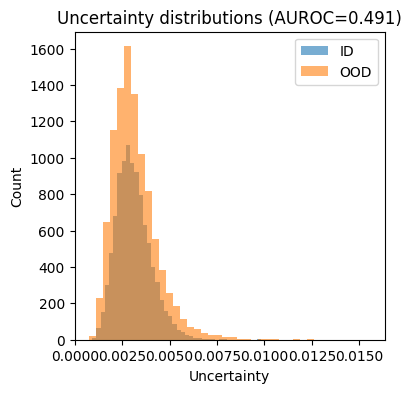

In [42]:
evaluate_ood_detection(unc_id, unc_ood)